In [3]:
# LOAD DATA

import os, csv
import pandas as pd
from pyspark.sql import SparkSession, functions, types
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.feature import StringIndexer, VectorAssembler, SQLTransformer
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

spark = SparkSession.builder.getOrCreate()
spark.sparkContext.setLogLevel('WARN')

# Read in data. We need to read in the first row of the CSV 
# to get the headers so we can dynamically create the schema.
DATA_DIR = 'project_data/peaks_v2'
file_name = 'peak_1s.csv'

pd_df = pd.read_csv(os.path.join(DATA_DIR, file_name))
df = spark.createDataFrame(pd_df)

# confirm the labels are right
labels = df.select(df['label']).collect()
falls = [l for l in labels if l[0] == 1]
non_falls = [l for l in labels if l[0] == 0]
print("Falls: {}, Non-falls: {}".format(len(falls), len(non_falls)))

# Get all columns except trial_id and label as features
# May need to tweak this if using non-windowed data
# max_cols = [col for col in df.columns if col.endswith('max')] + ['trial', 'label', 'start_time']
# df = df.select(max_cols)
features = [col for col in df.columns if col not in ['trial', 'label', 'filename']]
train, validation = df.randomSplit([0.75, 0.25])

print('done')

Falls: 3990, Non-falls: 60615
done


Results for r_ank
Test Area Under ROC: 0.9777933367827609
Test Area Under PR: 0.6784733062105199
f1: 0.9614103889940224
Weighted Precision: 0.9615447406486834
Weighted Recall: 0.9612811299715028
Accuracy: 0.961281129971503

Normalized confusion matrix


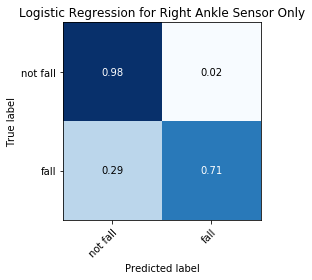

Results for l_ank
Test Area Under ROC: 0.9836394657762921
Test Area Under PR: 0.7097826367251465
f1: 0.9423264872953161
Weighted Precision: 0.9433921817883294
Weighted Recall: 0.950923317683881
Accuracy: 0.950923317683881

Normalized confusion matrix


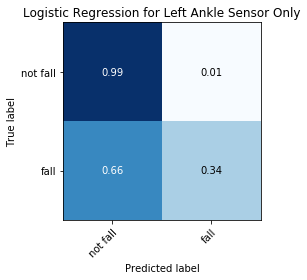

Results for r_thi
Test Area Under ROC: 0.9832260272422058
Test Area Under PR: 0.7729806319092006
f1: 0.9400343134534435
Weighted Precision: 0.9469887166421188
Weighted Recall: 0.9518132141082961
Accuracy: 0.9518132141082961

Normalized confusion matrix


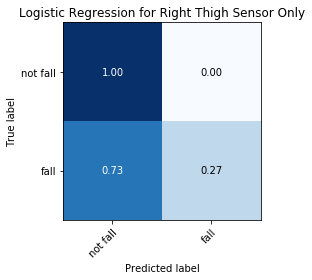

Results for l_thi
Test Area Under ROC: 0.9808498458205581
Test Area Under PR: 0.7361688422978933
f1: 0.9515687959911447
Weighted Precision: 0.9537656666565156
Weighted Recall: 0.9578888613247333
Accuracy: 0.9578888613247333

Normalized confusion matrix


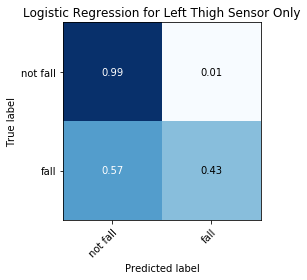

Results for hea
Test Area Under ROC: 0.9793271501701458
Test Area Under PR: 0.7066445762038474
f1: 0.9531658055942952
Weighted Precision: 0.9526246184586359
Weighted Recall: 0.9576430722891566
Accuracy: 0.9576430722891566

Normalized confusion matrix


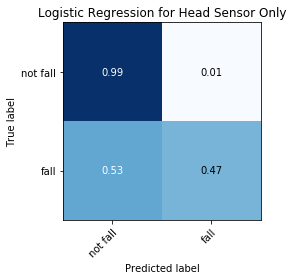

Results for wai
Test Area Under ROC: 0.9843720650891794
Test Area Under PR: 0.806752455479123
f1: 0.9535806202753819
Weighted Precision: 0.957589093663787
Weighted Recall: 0.9604354587869363
Accuracy: 0.9604354587869363

Normalized confusion matrix


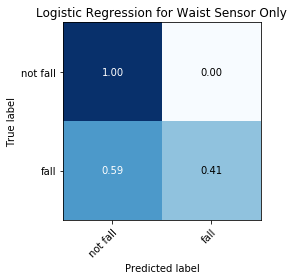

Results for ste
Test Area Under ROC: 0.9813759222655339
Test Area Under PR: 0.7652647435254729
f1: 0.9568240397362957
Weighted Precision: 0.9566281577731408
Weighted Recall: 0.9606824925816024
Accuracy: 0.9606824925816023

Normalized confusion matrix


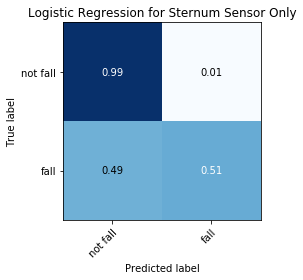

In [10]:
## LOGISTIC REGRESSION WITH ONE SENSOR
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import HashingTF, Tokenizer
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

sensors = ['r_ank', 'l_ank', 'r_thi', 'l_thi', 'hea', 'wai', 'ste'] 
sensor_rename = { "r_ank": "Right Ankle", "l_ank": "Left Ankle", "r_thi": "Right Thigh", "l_thi": "Left Thigh", "hea": "Head", "wai": "Waist", "ste": "Sternum" }
results = [] 
numFolds = 5
epochs = 100

# select columns for sensor only
for sensor in sensors:
    cols = [col for col in df.columns if col.startswith(sensor)] + ['trial_id', 'label']
    df_sensor = df.select(cols)
    features = [col for col in df_sensor.columns if col not in ['trial', 'label', 'filename']]
    train, validation = df_sensor.randomSplit([0.75, 0.25])

    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

    # Assemble Pipeline
    assembler = VectorAssembler(
        inputCols=features,
        outputCol='features')
    classifier = LogisticRegression(maxIter=epochs)
    pipeline = Pipeline(stages=[assembler, classifier])

    paramGrid = ParamGridBuilder() \
        .addGrid(hashingTF.numFeatures, [300]) \
        .addGrid(classifier.regParam, [0]) \
        .build()

    cv = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(metricName='weightedPrecision'),
                              numFolds=numFolds)  
    model = cv.fit(train)
    
    predictions = model.transform(validation)

    evaluator = BinaryClassificationEvaluator()
    print("Results for " + sensor)
    print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))
    print("Test Area Under PR: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})))

    evaluator = MulticlassClassificationEvaluator()
    print("f1: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "f1"})))
    print("Weighted Precision: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})))
    print("Weighted Recall: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})))
    print("Accuracy: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
    print("")
    
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
    precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})

    sensorResult = [sensor, precision, recall, f1, accuracy]
    results.append(sensorResult)
    
    # CONFUSION MATRIX
    class_names = [0, 1]
    y_pred = predictions.select(predictions['prediction']).toPandas().to_numpy().astype(np.int8)
    y_test = predictions.select(predictions['label']).toPandas().to_numpy().astype(np.int8)

    def plot_confusion_matrix(y_true, y_pred, classes,
                              normalize=False,
                              title=None,
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        # Only use the labels that appear in the data
        classes = ['not fall','fall']
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax


    np.set_printoptions(precision=2)

    plot_title = 'Logistic Regression for ' + sensor_rename[sensor] + ' Sensor Only'
    # Plot normalized confusion matrix
    plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                          title=plot_title)

    plt.savefig(plot_title + '.png')
    plt.show()

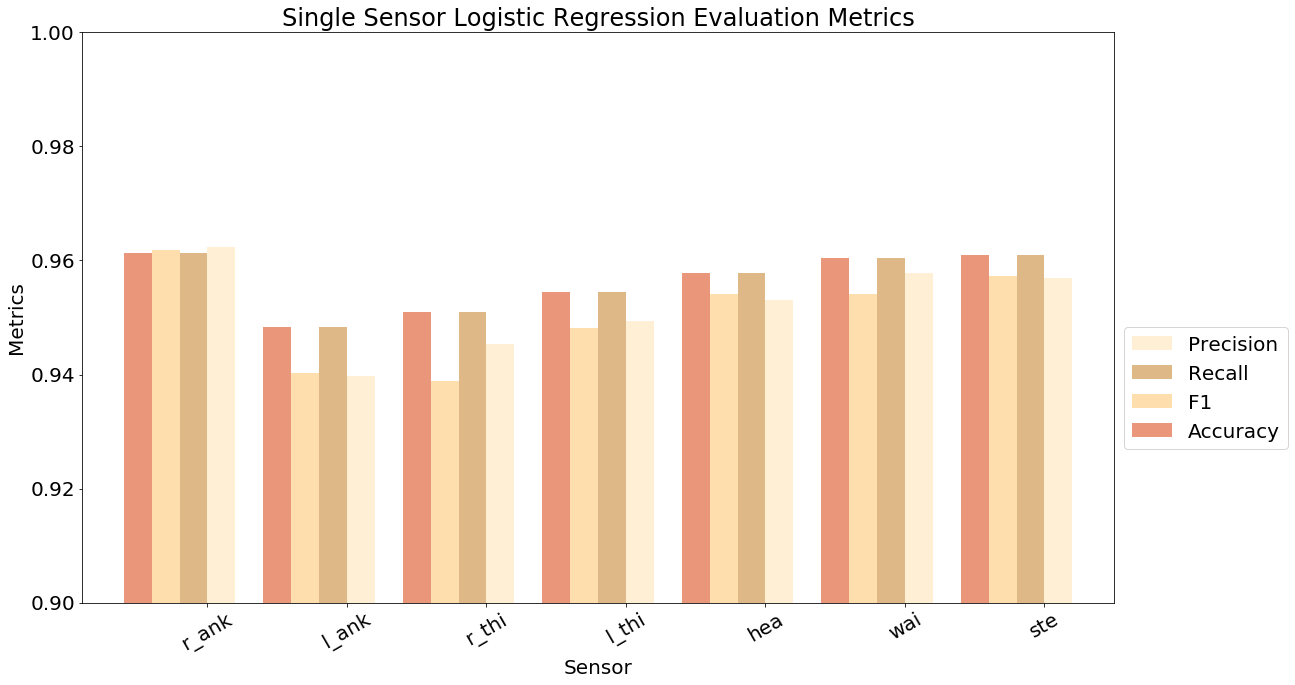

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO

%matplotlib inline

df_ss = pd.DataFrame(results, columns=['Sensor', 'Precision', 'Recall', 'F1', 'Accuracy'])
df_ss.index = df_ss.Sensor

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)


matplotlib.rcParams.update({'font.size': 20})

ax = fig.add_subplot(111) # Create matplotlib axes

width = 0.2

df_ss.Precision.plot(kind='bar', color='papayawhip', ax=ax, width=width, position=0,
                  label='Precision')
df_ss.Recall.plot(kind='bar', color='burlywood', ax=ax, width=width, position=1,
              label = 'Recall')
df_ss.F1.plot(kind='bar', color='navajowhite', ax=ax, width=width, position=2
          , label = 'F1')
df_ss.Accuracy.plot(kind='bar', color='darksalmon', ax=ax, width=width, position=3
                , label = 'Accuracy')

plt.legend()
ax.set_ylim([0.9,1])
ax.set_ylabel('Metrics')
ax.set_xlim([-0.9, 6.5])
ax.legend(['Precision', 'Recall', 'F1', 'Accuracy'], loc='top left', bbox_to_anchor=(1.0, 0.5));
ax.set_title('Single Sensor Logistic Regression Evaluation Metrics')
plt.xticks(rotation=30)
plt.savefig('single_sensor.png')
plt.show()

